# Playground
Let's get back in the game with pytorch and autoencoders. Given some toy dataset (mixture of Gaussians and MNIST), let's get some autoencoders encoding!

In [1]:
import sys
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.datasets import fetch_mldata
import torch.nn.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
%matplotlib inline

Some constants for the rest of the playground

## Toy data

Mixture of Gausians.

In [2]:
N1 = 10000
N2 = 3000
N = N1 + N2
X1 = np.random.multivariate_normal([3, 3], [[1, -.9], [-.9, 1]], size=N1)
X1 = torch.from_numpy(X1).type(torch.FloatTensor)
X2 = np.random.multivariate_normal([-5, -5], [[1.5, .7], [.7, 1.5]], size=N2)
X2 = torch.from_numpy(X2).type(torch.FloatTensor)
X = torch.cat([X1, X2])

S = .8
N_train = int(N * S)
split = torch.randperm(X.size(0))
X_train = X[split[:N_train]]
X_test = X[split[N_train:]]

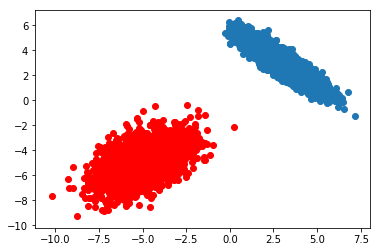

In [3]:
plt.scatter(*zip(*X1))
plt.scatter(*zip(*X2), c='r')
plt.show()

In [4]:
def get_batch(data, batch_size, allow_smaller_batch=False):
    N = data.shape[0]
    indexes = torch.randperm(N)
    for i in range(0, N, batch_size):
        if not allow_smaller_batch and i + batch_size > N - 1:
            break
        yield data[indexes[i: i + batch_size]]

## Basic autoencoder

### Mixture of Gaussian

In [13]:
def autoencoder(p, b):
    encoder = nn.Sequential(
            nn.Linear(p, 32),
            nn.ReLU(),
            nn.Linear(32, b))
    decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(b, 32),
            nn.ReLU(),
            nn.Linear(32, p))
    ae = nn.Sequential(encoder, decoder)
    return encoder, decoder, ae

encoder, decoder, net1 = autoencoder(p=2, b=2)

In [14]:
optimizer = torch.optim.Adam(params=net1.parameters(), lr=0.01)
criterion = lambda x,y: ((x - y) ** 2).sum(1).mean()

In [15]:
batch_size = 32
max_epochs = 20
for i in range(max_epochs):
    loss_agg = []
    for x in get_batch(X_train, batch_size):
        net1.train()
        x = Variable(x)
        x_ = net1(x)
        net1.zero_grad()
        loss = criterion(x, x_)
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.numpy())
    print('[%i/%i] loss %.4f' % (i+1, max_epochs, np.mean(loss_agg)))

[1/20] loss 1.6388
[2/20] loss 0.0938
[3/20] loss 0.0052
[4/20] loss 0.0049
[5/20] loss 0.0039
[6/20] loss 0.0072
[7/20] loss 0.0013
[8/20] loss 0.0088
[9/20] loss 0.0031
[10/20] loss 0.0018
[11/20] loss 0.0085
[12/20] loss 0.0038
[13/20] loss 0.0045
[14/20] loss 0.0031
[15/20] loss 0.0033
[16/20] loss 0.0038
[17/20] loss 0.0045
[18/20] loss 0.0032
[19/20] loss 0.0046
[20/20] loss 0.0040


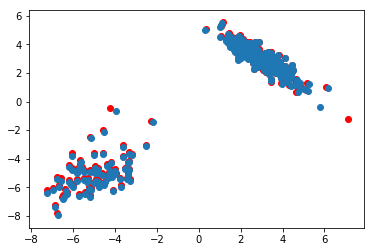

In [16]:
net1.eval()
idx = torch.randperm(X_test.size(0))[:300]
x_ = net1(Variable(X_test[idx]))
loss = criterion(x_, Variable(X_test[idx]))
loss.data.numpy()

plt.scatter(*zip(*X_test[idx]), c='r')
plt.scatter(*zip(*x_.data.numpy()))

Let's plot the latent space.

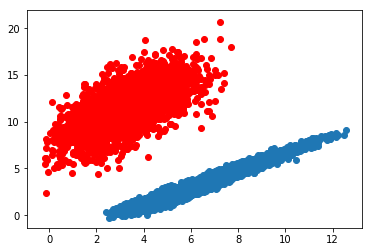

In [17]:
code1, code2 = encoder(Variable(X1)), encoder(Variable(X2))
plt.scatter(*zip(*code1.data.numpy()[:, :2]))
plt.scatter(*zip(*code2.data.numpy()[:, :2]), c='r');
# plt.hist(code1.data.numpy())
# plt.hist(code2.data.numpy());

### MNIST

In [18]:
mnist = fetch_mldata('MNIST original', data_home='.')

In [19]:
mnist.data = mnist.data.astype(np.float32) / 255
mnist.data = (mnist.data - 0.1307) / 0.3081

A few helper functions.

In [20]:
def visualize(net, data, in_size, seed=42):
    np.random.seed(seed=seed)
    in_size = tuple([-1] + in_size)
    idx = np.random.choice(range(0, data.shape[0]), size=10, replace=False)
    images = torch.from_numpy(data[idx]).view(in_size)
    images = Variable(images)
    reconstructions = net(images)
    reconstructions = reconstructions.data.cpu().numpy()
    images = images.data.cpu().numpy()
    reconstructions = reconstructions.reshape((-1, 1, 28, 28))
    images = images.reshape((-1, 1, 28, 28))

    fig = plt.figure(figsize=(6, 6))
    for i in range(10):
        a = fig.add_subplot(10, 10, i + 1)
        b = fig.add_subplot(10, 10, i + 11)
        a.axis('off')
        b.axis('off')
        im = images[i - 1].squeeze()
        rec = reconstructions[i - 1].squeeze()
        a.imshow(im, cmap='Greys_r')
        b.imshow(rec, cmap='Greys_r');
       
    
def progress(loss, epoch, max_epoch, step, batch, N, start):
    progress = min(step * batch / N * 100, 100)
    flush = '\n' if progress >= 100 else ''
    digits = len(str(max_epochs))
    elapsed = time.time() - start
    v = (progress / 100 * N) / elapsed
    sys.stdout.write('\r[%*d/%*d][%50s] %2d%% – loss %.3f - %4is [%i fps]%s' %
                (digits, epoch, digits, max_epoch, '=' * int(progress/2) + ' ' * (50 - int(progress/2)), progress, np.mean(loss), elapsed, v, flush))

In [161]:
net2 = nn.Sequential(
                # Encoder
                nn.Linear(28 * 28, 512),
                nn.PReLU(512),
                nn.BatchNorm1d(512),
    
                # Low-dimensional representation
                nn.Linear(512, 128),   
                nn.PReLU(128),
                nn.BatchNorm1d(128),
    
                # Decoder
                nn.Linear(128, 512),
                nn.PReLU(512),
                nn.Linear(512, 28 * 28))
optimizer = torch.optim.Adam(params=net2.parameters(), lr=0.01)

In [162]:
max_epochs = 10
batch_size = 300
N = mnist.data.shape[0]
for i in range(max_epochs):
    loss_agg = []
    start = time.time()
    for j, x in enumerate(get_batch(mnist.data, batch_size, allow_smaller_batch=True)):
        x = Variable(torch.from_numpy(x).float())
        x = x.view(x.size(0), -1)
        net2.zero_grad()
        x_ = net2(x)
        loss = torch.dist(x, x_) 
        loss.backward()
        optimizer.step()
        #loss = torch.sqrt(loss * 300)
        #loss = loss / x.size(0)
        #loss = torch.sqrt(loss ** 2 / x.size(0) * 300)
        loss_agg.append(loss.data.numpy())
        progress(loss_agg, i + 1, max_epochs, j + 1, batch_size, N, start)

[ 1/10][==================================================] 100% – loss 204.878 -   17s [3956 fps]
[ 2/10][==================================================] 100% – loss 134.511 -   15s [4422 fps]
[ 3/10][==================================================] 100% – loss 117.420 -   16s [4249 fps]
[ 4/10][==================================================] 100% – loss 108.503 -   17s [3934 fps]
[ 5/10][==================================================] 100% – loss 103.952 -   17s [4061 fps]
[ 6/10][==================================================] 100% – loss 100.924 -   24s [2888 fps]
[ 7/10][==================================================] 100% – loss 98.333 -   24s [2847 fps]
[ 8/10][==================================================] 100% – loss 97.349 -   25s [2707 fps]
[ 9/10][==================================================] 100% – loss 95.765 -   19s [3589 fps]
[10/10][==================================================] 100% – loss 94.651 -   16s [4329 fps]


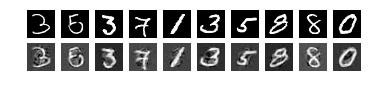

In [72]:
visualize(net2, mnist.data[:55000], in_size=[28*28])

In [165]:
net3  = nn.Sequential(
                # Encoder
                nn.Conv2d(1, 32, 3, padding=1), # input (1, 28, 28), output (32, 28, 28)
                nn.PReLU(32),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2), # (32, 14, 14)
                nn.Conv2d(32, 64, 3), # (64, 12, 12)
                nn.PReLU(64),
                nn.BatchNorm2d(64),
                nn.MaxPool2d(2), # (64, 6, 6))
                
                # Low-dimensional representation
                nn.Conv2d(64, 8, 3), # (8, 4, 4) -- latent representation
                nn.PReLU(8),
                nn.BatchNorm2d(8),
                
                # Decoder
                nn.Conv2d(8, 64, 3, padding=2), # (64, 6, 6)
                nn.Upsample(scale_factor=2), # (64, 12, 12)
                nn.Conv2d(64, 32, 3, padding=2), # (32, 14, 14)
                nn.PReLU(32),
                nn.Upsample(scale_factor=2), # (32, 28, 28)
                nn.Conv2d(32, 1, 3, padding=1))
optimizer = torch.optim.Adam(params=net3.parameters(), lr=0.01)

In [166]:
N = mnist.data.shape[0]
batch_size = 300
max_epochs = 5
for i in range(max_epochs):
    loss_agg = []
    start = time.time()
    for j, x in enumerate(get_batch(mnist.data, batch_size, allow_smaller_batch=True)):
        x = Variable(torch.from_numpy(x).float().view(-1, 1, 28, 28))
        x_ = net3(x)
        net3.zero_grad()
        loss = torch.dist(x, x_)
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.numpy())
        progress(loss_agg, i + 1, max_epochs, j + 1, batch_size, N, start)
    #print('[%i/%i] loss %.4f' % (i+1, max_epochs, np.mean(loss_agg)))

[1/5][==================================================] 100% – loss 172.975 -  483s [144 fps]
[2/5][==================================================] 100% – loss 122.215 -  513s [136 fps]
[3/5][==================================================] 100% – loss 114.976 -  524s [133 fps]
[4/5][==================================================] 100% – loss 108.996 -  465s [150 fps]
[5/5][==================================================] 100% – loss 107.635 -  491s [142 fps]


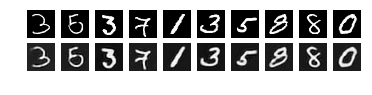

In [167]:
visualize(net3, mnist.data[:55000], in_size=[1, 28, 28])

In [204]:
class Autoencoder(nn.Module):
    def __init__(self, zdim=8):
        super(Autoencoder, self).__init__()
        self.iterations = 0
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, 3, padding=1, stride=2),
                nn.PReLU(32),
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 64, 3, padding=1, stride=2),
                nn.PReLU(64),
                nn.BatchNorm2d(64),
                nn.Conv2d(64, zdim, 7, padding=0, stride=2), # (8, 4, 4) -- latent representation
                )
        self.decoder = nn.Sequential(
                nn.PReLU(zdim),
                nn.BatchNorm2d(zdim),
                nn.ConvTranspose2d(zdim, 64, 7, stride=2, padding=0),
                nn.PReLU(64),
                nn.BatchNorm2d(64),
                nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
                nn.PReLU(32),
                nn.BatchNorm2d(32),
                nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1))

    def encode(self, x):
        print(x.size()) if not self.iterations else _
        for l in self.encoder:
            x = l(x)
            print(x.size(), l) if not self.iterations else _
        return x
    
    def decode(self, x):
        print(x.size()) if not self.iterations else _
        for l in self.decoder:
            x = l(x)
            print(x.size(), l) if not self.iterations else _
        return x
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        self.iterations += 1
        return x

zdim = 3
net4 = Autoencoder(zdim)
optimizer = torch.optim.Adam(params=net4.parameters(), lr=0.01)

In [207]:
max_epochs = 5
for i in range(max_epochs):
    loss_agg = []
    start = time.time()
    for j, x in enumerate(get_batch(mnist.data, batch_size, allow_smaller_batch=True)):
        x = Variable(torch.from_numpy(x).float().view(-1, 1, 28, 28))
        x_ = net4(x)
        net4.zero_grad()
        loss = torch.dist(x, x_)
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.numpy())
        progress(loss_agg, i + 1, max_epochs, j + 1, batch_size, N, start)

[1/5][==================================================] 100% – loss 299.296 -  142s [491 fps]
[2/5][==================================================] 100% – loss 298.220 -  140s [497 fps]
[3/5][==================================================] 100% – loss 297.367 -  140s [496 fps]
[4/5][==================================================] 100% – loss 296.564 -  140s [497 fps]
[5/5][==================================================] 100% – loss 296.011 -  140s [497 fps]


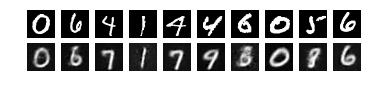

In [208]:
visualize(net4, mnist.data[60000:], in_size=[1, 28, 28])

## Adversarial autoencoder

In [180]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.iterations = 0
        self.encoder_top = nn.Sequential(
                            nn.Conv2d(1, 64, 3, padding=1, stride=2),
                            nn.PReLU(64),
                            nn.BatchNorm2d(64),
                            nn.Conv2d(64, 64, 3, padding=1, stride=2), # (64, 12, 12)
                            nn.PReLU(64),
                            nn.BatchNorm2d(64),
                            nn.Conv2d(64, 8, 3, padding=1, stride=2), # (8, 4, 4)
                            nn.ReLU(),
                            nn.BatchNorm2d(8))
        self.encoder_bottom = nn.Sequential(
                            nn.Linear(8 * 4 * 4, 128),
                            nn.ReLU(),
                            nn.Linear(128, z_dim))

    def forward(self, x):
        print(x.size()) if not self.iterations else _
        for l in self.encoder_top:
            x = l(x)
            print(x.size(), l) if not self.iterations else _
            
        x = x.view(x.size(0), -1)
        print(x.size()) if not self.iterations else _
        
        for l in self.encoder_bottom:
            x = l(x)
            print(x.size(), l) if not self.iterations else _
        self.iterations += 1
        return x


class Decoder(nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.iterations = 0
        self.decoder_top = nn.Sequential(
                            nn.Linear(z_dim, 128),
                            nn.ReLU(),
                            nn.BatchNorm1d(128),
                            nn.Linear(128, 8 * 4 * 4),
                            nn.ReLU(),
                            nn.BatchNorm1d(8 * 4 * 4))
        self.decoder_bottom = nn.Sequential(
                            nn.ConvTranspose2d(8, 64, 3, stride=2, padding=1),
                            nn.PReLU(64),
                            nn.BatchNorm2d(64),
                            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
                            nn.PReLU(64),
                            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1),
                            nn.Sigmoid()) # (1, 28, 28)

        
    def forward(self, x):
        print(x.size()) if not self.iterations else _
        for l in self.decoder_top:
            x = l(x)
            print(x.size(), l) if not self.iterations else _
            
        x = x.view(x.size(0), 8, 4, 4)
        print(x.size()) if not self.iterations else _
        
        for l in self.decoder_bottom:
            x = l(x)
            print(x.size(), l) if not self.iterations else _
        self.iterations += 1
        return x
  
    
z_dim = 3
discriminator5 = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.PReLU(128),
            nn.BatchNorm1d(128),
            nn.Linear(128, 32),
            nn.PReLU(32),
            nn.Linear(32, 1),
            nn.Sigmoid())

encoder5 = Encoder(z_dim)
decoder5 = Decoder(z_dim)
net5 = nn.Sequential(encoder5, decoder5)

In [181]:
lr = 0.01 # learning rate
criterion = nn.BCELoss()
optimizer_ae = torch.optim.Adam(params=net5.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(params=discriminator5.parameters(), lr=0.005)
optimizer_g = torch.optim.Adam(params=encoder5.parameters(), lr=lr)

In [182]:
info = {}
info['recon_loss'] = []
info['discriminator_loss'] = []
info['generator_loss'] = []

max_epochs = 10
for i in range(max_epochs):
    start = time.time()
    for j, x in enumerate(get_batch(mnist.data, batch_size, allow_smaller_batch=True)):
        batch = x.shape[0]
        ones = Variable(torch.ones(batch))
        zeros = Variable(torch.zeros(batch))
        
        # (1) Reconstruction loss
        encoder5.zero_grad()
        decoder5.zero_grad()
        discriminator5.zero_grad()
        x = Variable(torch.from_numpy(x).float().view(-1, 1, 28, 28))
        x_ = net5(x)
        reconstruction_loss = torch.dist(x, x_)
        reconstruction_loss.backward()
        optimizer_ae.step()
        
        # (2) Train the discriminator
        discriminator5.zero_grad()
        z_fake = encoder5(x.detach())
        z_real = Variable(torch.randn(z_fake.size()))
        z_fake_d = discriminator5(z_fake)
        z_real_d = discriminator5(z_real)

        loss_real = criterion(z_real_d, ones)
        loss_fake = criterion(z_fake_d, zeros)
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # (3) Generator step
    
        encoder5.zero_grad()
        z_fake = encoder5(x)
        z_fake_d = discriminator5(z_fake)
        loss_g = criterion(z_fake_d, ones)
        loss_g.backward()
        optimizer_g.step()
    
        
        info['recon_loss'].append(reconstruction_loss.data[0])
        info['discriminator_loss'].append(loss_d.data[0])
        info['generator_loss'].append(loss_g.data[0])
        
        progress(info['recon_loss'], i + 1, max_epochs, j + 1, batch_size, N, start)
    print('[%2i/%2i] recon_loss %.3f D_loss %.3f G_loss %.3f' %
      (i + 1, max_epochs, np.mean(info['recon_loss']),
       np.mean(info['discriminator_loss']), np.mean(info['generator_loss'])))

    info['recon_loss'] = []
    info['discriminator_loss'] = []
    info['generator_loss'] = []

torch.Size([300, 1, 28, 28])
torch.Size([300, 64, 14, 14]) Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
torch.Size([300, 64, 14, 14]) PReLU(num_parameters=64)
torch.Size([300, 64, 14, 14]) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
torch.Size([300, 64, 7, 7]) Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
torch.Size([300, 64, 7, 7]) PReLU(num_parameters=64)
torch.Size([300, 64, 7, 7]) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
torch.Size([300, 8, 4, 4]) Conv2d(64, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
torch.Size([300, 8, 4, 4]) ReLU()
torch.Size([300, 8, 4, 4]) BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
torch.Size([300, 128])
torch.Size([300, 128]) Linear(in_features=128, out_features=128, bias=True)
torch.Size([300, 128]) ReLU()
torch.Size([300, 3]) Linear(in_features=128, out_features=3, bias=True)
torch.Size([300, 3])
torch.Size([300, 128]) Linear(in_features=3, out_features=128, bias=True)
torch.

/Users/bmyara/miniconda3/envs/torch/lib/python3.6/site-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[ 1/10][=====================                             ] 42% – loss 415.786 -  202s [148 fps]

KeyboardInterrupt: 

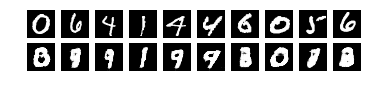

In [183]:
visualize(net5, mnist.data[60000:], in_size=[1, 28, 28])

In [296]:
n = 10000
idx = np.random.choice(range(70000), size=n, replace=False)
images, labels = mnist.data[idx], mnist.target[idx]
images = Variable(torch.from_numpy(images))
images = images.view((-1, 1, 28, 28))
code = encoder5(images)

In [298]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = pylab.figure()
ax = Axes3D(fig)

ax.scatter(*zip(*code.data.numpy()[:, :3]), c=labels);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>